In [1]:
from ngsolve import *
from ngsolve.webgui import Draw
import numpy as np
import scipy.optimize
import csv

class gel_3D:
    def __init__(self,length=90.0, thickness=3.0, width =23.5, delta=0.9):
        self.phi0 = 0.2
        self.entropic_unit = 136.6  # measured in MPa
        self.G = 0.13               # measured in MPa
        self.gamma = self.G/self.entropic_unit # 0.0009516837481698391 self.compute_gamma( lamb =1.4874):
        self.lambda_target = 1.99  # 0.13/136.3 = gammafun(1.99)
        self.chi =  0.348 # compute_chi(phi0=0.2035, gamma =0.0009516837481698391, J=J_iso)
        self.density =  1.23 # measured in [g/mL]


        self.L = length      # measured in mm
        self.d = thickness    # measured in mm
        self.w = width # measured in mm
        self.delta = delta   # dimensionless
        
        def auxIsotropic(s):
            return s*self.dH(s*s*s) + self.gamma
        self.lambda_iso = (scipy.optimize.fsolve(auxIsotropic, 1.7))[0]

        lambda_iso = self.lambda_iso
        self.reference_energy_density = self.auxEnergyDensity(lambda_iso, lambda_iso, lambda_iso)
        
        gel = self
        self.lambdaUniaxial = (scipy.optimize.fsolve(self.auxFunctionUniaxial, 2))[0]
        lambdaUniaxial = gel.lambdaUniaxial
        self.wUniaxial = self.auxEnergyDensity(1, lambdaUniaxial, 1)  - gel.reference_energy_density
        
        self.lambdaEquiBiaxial = (scipy.optimize.fsolve(self.auxFunctionEquibiaxial, 2))[0]
        lambdaEquiBiaxial = gel.lambdaEquiBiaxial
        self.wEquiBiaxial = self.auxEnergyDensity(lambdaEquiBiaxial, lambdaEquiBiaxial, 1) - gel.reference_energy_density

    def auxEnergyDensity(self, lambda1, lambda2, lambda3):
        gel=self
        phi0=gel.phi0;
        G=gel.G;
        chi=gel.chi;
        nu=gel.entropic_unit
            
        J= lambda1*lambda2*lambda3;
        phi = phi0/J;
        return 0.5*G*(lambda1**2 + lambda2**2 + lambda3**2) + nu*((J-phi0)*np.log(1-phi) + phi0*chi*(1-phi))
    
    def auxFunctionEquibiaxial(self,s):
        return self.dH(s*s) + self.gamma
    
    def auxFunctionUniaxial(self,s):
        gel = self
        return gel.dH(s) + gel.gamma*s

    def phi(self, J):
        return self.phi0/J

    def H(self, J):
        return (J - self.phi0)*log(1-self.phi(J))  + self.phi0 * self.chi*(1-self.phi(J))

    def dH(self, J):
        return self.phi(J) + np.log(1-self.phi(J)) + self.chi * self.phi(J)**2

    def Gfun(self, lamb):
        nu = self.entropic_unit
        return (-self.dH(lamb)/lamb)*nu
        
    # energy density in [MPa]
    def W(self, F):
               
        J = Det(F)
        C = F.trans* F
        
        gel = self
        G = gel.G
        nu = gel.entropic_unit
        
        reference_energy_density =  self.reference_energy_density
        
        return 0.5*G*(Trace(C)) + nu*gel.H(J) - reference_energy_density

In [3]:
### Main ###

# More stable parameters
G = 0.13               # measured in MPa
entropic_unit = 136.6  # k_B*T/V_m measured in MPa
phi0 = 0.2
chi =  0.348           # J. Elast. 2022, Sect. 3.4
rho = 1.23e-6          # measured in kg/mm³
g = 9.8                # measured in m/s²
AA = 1e5

# Most commonly changed parameters
order = 2
coarse_flag = 0

#Specify the geometry here
thickness = 3.00
# thickness = 1.62

if thickness==3.00:
    L= 90.0
    d = 3.00
    w = 23.5
elif thickness==1.62:
    L= 90.0
    d = 1.62
    w = 15.0

# indexes_deltas = [8,7,6,5,4,3,2,1,0]
# indexes_deltas = [8,7,6,5,4,3,2,1,0]
# indexes_deltas = [9,8]
# indexes_deltas = range(0,9+1)
# indexes_deltas = [8,5,3,0]
###
first_index_delta = 0
last_index_delta = 9
indexes_deltas = range(first_index_delta, last_index_delta+1)

width_test_region = 30
zeta = IfPos((width_test_region/2 -x)*(x + width_test_region/2),1.0, 0) #*IfPos((9-z)*(z+9),1, 0)
# zeta = 1.0

##
gel = gel_3D(length=L, thickness=d,width=w)
gravity = CoefficientFunction((0,-g, 0))

lambdaUniaxial = gel.lambdaUniaxial
lambdaEquiBiaxial = gel.lambdaEquiBiaxial
lambda_iso = gel.lambda_iso
wUniaxial = gel.wUniaxial
wEquiBiaxial = gel.wEquiBiaxial
wIso = 0

print('Uniaxial and equi-biaxial energy densities [kPa]={:.1f} and {:.1f} '.format(1000*wUniaxial,1000*wEquiBiaxial))


##
folder_name_suffix = str(int(d)) + '_' + str(int(d%1*100)).zfill(2)
if coarse_flag!=0:
    folder_name_suffix += '_coarse'
delta_values = np.loadtxt('meshes' + folder_name_suffix + '/deltas')

aux_spamwriter = []

aux_csv = [] 
aux_csv.append('d [mm]')
aux_csv.append('delta')
aux_csv.append('nDof')
aux_csv += ['(a)', '(b)', '(c)', '(d)', '(e)']
aux_csv.append('Average energy density [kPa]')
aux_csv.append('Gravitational Energy [mJ]')
aux_csv.append('Total energy [mJ]')
aux_csv.append('Theoretical 2D energy [mJ]')
aux_csv.append('Cross-section average energy density [kPa]')

aux_spamwriter.append(aux_csv)

for index_delta in indexes_deltas:
    mesh_file = 'meshes' + folder_name_suffix + '/mesh{}.vol.gz'.format(index_delta);
    #mesh_file = 'meshes' + folder_name_suffix + '/mesh{}.vol'.format(index_delta);
    mesh = Mesh(mesh_file)
    Draw(mesh)
    # Draw(zeta, mesh)
    aux_csv = [] 
    aux_csv.append(round(d, 2))
    
    delta = delta_values[index_delta];
    print('------')
    print("Mesh number = {}, delta={:.3f}".format(index_delta,delta))
    aux_csv.append(round(delta,1))

    # fes = VectorH1(mesh, order=order, dirichlet="bonded_interface", dirichlety="debonded_interface")
    # fes = VectorH1(mesh, order=order, dirichlet="bonded_interface")
    # fes = VectorH1(mesh, order=order)
    # if index_delta <= 8:
    #     fes = VectorH1(mesh, order=order, dirichlet="bonded", dirichlety="debonded")
    # elif index_delta == 9:
    #     fes = VectorH1(mesh, order=order, dirichlet="bonded|debonded")
    fes = VectorH1(mesh, order=order, dirichlet="bonded", dirichlety="debonded")
    print('Ndof: ', fes.ndof)
    aux_csv.append(fes.ndof)

    filename_suffix = "_d={:.2f}_delta={:.3f}".format(d, delta)
    filename='gridfunctions'+folder_name_suffix+\
                '/result_debonded3D'+filename_suffix+\
                "_order={}".format(order)\
    # filename='gridfunctions3_00/result_debonded3D_d=3.00_order=2'

    u = GridFunction(fes)
    u.Load(filename + '.gfu')
    #Draw(u_noExtraBC, deformation=True)
    F = Id(3) + Grad(u)

   
    ###    

    aux_width = np.array(u(mesh(-gel.L/2, gel.d,gel.w/2))) - np.array(u(mesh(-gel.L/2, gel.d,-gel.w/2)))
    deformed_width = aux_width[2] # + gel.w
    print('Swelling (a) Deformed width at the left = {:.2f} [mm]'.format(deformed_width))
    aux_csv.append(round(deformed_width,2))

    aux_width = np.array(u(mesh(0, gel.d,gel.w/2))) - np.array(u(mesh(0, gel.d,-gel.w/2)))
    deformed_width_at_the_middle = aux_width[2] # + gel.w
    print('Swelling (b) Deformed width at the middle = {:.2f} [mm]'.format(deformed_width_at_the_middle))
    aux_csv.append(round(deformed_width_at_the_middle,2))

    deformed_length = (u(mesh(gel.L/2, gel.d,0)))[0] - (u(mesh(-gel.L/2, gel.d,0)))[0] # + gel.L
    print('Swelling (c) Deformed length = {:.2f} [mm]'.format(deformed_length))
    aux_csv.append(round(deformed_length,2))

    #aux_csv.append(round(gel.L*delta,1))

    aux_thickness = np.array(u(mesh(-gel.L/2, gel.d, 0)))
    deformed_thickness = aux_thickness[1] # + gel.d
    print('Swelling (d) Deformed thickness at the left = {:.2f} [mm]'.format(deformed_thickness))
    aux_csv.append(round(deformed_thickness,2))

    aux_thickness = np.array(u(mesh(0, gel.d, 0)))
    deformed_thickness = aux_thickness[1] # + gel.d
    print('Swelling (e) Deformed_thickness at the middle ={:.2f} [mm]'.format(deformed_thickness))
    aux_csv.append(round(deformed_thickness,2))
    
    ### Energies
    GF_energy_density = GridFunction(H1(mesh, order=1))
    GF_energy_density.Set(gel.W(F))
    
    # elasticEnergy = Integrate(gel.W(F), mesh, order=5)
    elasticEnergy = Integrate(GF_energy_density, mesh, order=5)
    averageEnergyDensity = elasticEnergy/(L*d*w)
    gravitationalEnergyFreeSwelling =  rho*g*L*w*(d**2)/2*(gel.lambda_iso-1)    # measured in [mJ]
    gravitationalEnergy = Integrate(- rho*InnerProduct(gravity, u), mesh, order=5) - gravitationalEnergyFreeSwelling

    print('Average energy density [kPa] = ', round(averageEnergyDensity*1000,1))
    print('Gravitational Energy [mJ]:', gravitationalEnergy )
    aux_csv.append(round(averageEnergyDensity*1000,1))
    aux_csv.append(round(gravitationalEnergy,5))

    numericalEnergy = elasticEnergy + gravitationalEnergy
    print('Total energy [mJ]: {:.2f}'.format(numericalEnergy))    
    aux_csv.append(round(numericalEnergy,2))

    gravitationalEnergy2D = + rho*g*L*w*(d**2)/2*(delta*(lambdaUniaxial-1) + (1-delta)*(lambdaEquiBiaxial-1)) - gravitationalEnergyFreeSwelling
    theoreticalEnergy2D = gravitationalEnergy2D + (((L*delta)*d*w*wUniaxial + (L*(1-delta))*d*w*wEquiBiaxial))
    print('Theoretical energy [mJ]: {:.2f}'.format(theoreticalEnergy2D))
    aux_csv.append(round(theoreticalEnergy2D,2))

    crossSectionElasticEnergy = Integrate(zeta*GF_energy_density, mesh, order=5)
    crossSectionEnergyDensity = crossSectionElasticEnergy/(width_test_region*d*w)  # in [MPa]
    print('Cross-section average energy density [kPa] = ', round(crossSectionEnergyDensity*1000,1))
    aux_csv.append(round(crossSectionEnergyDensity*1000,1))
    
    #print('(Equi-biaxial energy density = {:.3f}. Uniaxial energy density = {:.3f}.)'.format(wEquiBiaxial, wUniaxial))

    # Draw(mesh)
    # Draw(gel.W(F)*1e3, mesh, deformation=u, min =0.0, max = 152.0)        # Energy densities in [KPa]
    GF_energy_density = GridFunction(H1(mesh, order=1))
    GF_energy_density.Set(gel.W(F)*1e3)

    filevtk = 'gridfunctions'+folder_name_suffix+\
                '/result_debonded3D'+filename_suffix+\
                "_order={}".format(order)
    vtk = VTKOutput(mesh,coefs=[u, GF_energy_density],names=["u", "energy density"],filename=filevtk,subdivision=1)
    
    vtk.Do()

    print(' ')

    aux_spamwriter.append(aux_csv)
    

with open('summary_results' + '_d={:.2f}'.format(d) +'.csv', 'w') as csvfile:
    spamwriter = csv.writer(csvfile)
    spamwriter.writerows(aux_spamwriter)


Uniaxial and equi-biaxial energy densities [kPa]=152.1 and 48.3 


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

------
Mesh number = 0, delta=0.100
Ndof:  585441


NgException: File gridfunctions3_00/result_debonded3D_d=3.00_delta=0.100_order=2.gfu does not exist!

Energy of the uniaxial expansion = 964.81 [mJ]
Energy of the equi-biaxial expansion = 306.76 [mJ]

R^2 score = 0.9993216
Lower bound for the energy release rate: 311.16 [J/m^2]
Energy release rate = 329.60 [J/m²]
For an adhesion toughness of 1100 [J/m^2], the threshold thickness is 10.01 [mm]

Plot saved at ./figures/energies_d=3.00.pdf

   d [mm]  delta    nDof    (a)   (b)    (c)   (d)   (e)  \
0     3.0    0.1  585441  11.45  6.10  42.39  1.46  2.58   
1     3.0    0.2  589590  11.46  6.98  38.47  1.46  2.79   
2     3.0    0.3  590265  11.50  7.40  34.18  1.46  2.85   
3     3.0    0.4  591831  11.60  7.53  29.87  1.45  2.87   
4     3.0    0.5  595797  11.82  7.59  25.64  1.44  2.88   
5     3.0    0.6  593214  12.16  7.61  21.57  1.41  2.88   
6     3.0    0.7  418509  12.51  7.62  17.66  1.39  2.88   
7     3.0    0.8  413709  12.20  7.62  13.76  1.41  2.88   
8     3.0    0.9  415089   9.68  7.62   9.31  1.49  2.88   
9     3.0    1.0  508089   5.37  7.62   7.24  0.17  2.88   


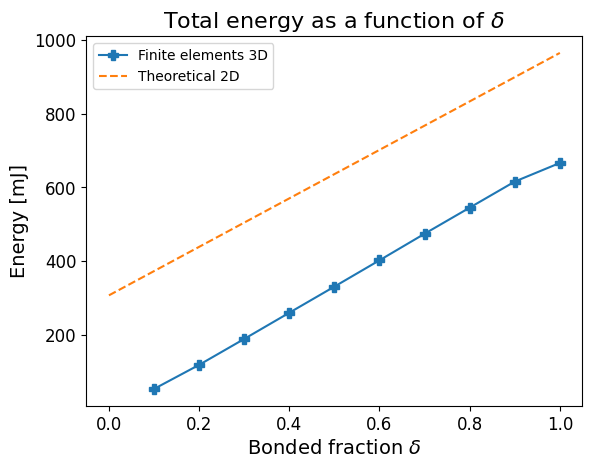

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression

# d=1.62; w=15.0
# d=3.00; w=23.50

print('Energy of the uniaxial expansion = {:.2f} [mJ]'.format((wUniaxial*1e6)*(L/1e3)*(d/1e3)*(w/1e3)*1e3))
print('Energy of the equi-biaxial expansion = {:.2f} [mJ]\n'.format((wEquiBiaxial*1e6)*(L/1e3)*(d/1e3)*(w/1e3)*1e3))

df = pd.read_csv("summary_results_d={:.2f}.csv".format(d))

# Linear regression
deltas = df[['delta']]
energies = df['Total energy [mJ]']
model = LinearRegression()
model.fit(deltas, energies)
r2_score = model.score(deltas, energies)
print('R^2 score = {:.7f}'.format(r2_score))
m  = model.coef_[0]
n = model.intercept_

lower_bound_release_rate = (rho*g*L*w*(d**2)/2*(lambdaUniaxial - lambdaEquiBiaxial) + L*d*w*(wUniaxial - wEquiBiaxial))*(1e-3)/((L/1e3)*(w/1e3))
print('Lower bound for the energy release rate: {:.2f} [J/m^2]'.format(lower_bound_release_rate))
energy_release_rate = (m*1e-3)/((L/1e3)*(w/1e3))                           # in [J/m^2]
print('Energy release rate = {:.2f} [J/m²]'.format(energy_release_rate))

adhesion_toughness = 1100                                                  # in [J/m^2]
print('For an adhesion toughness of {} [J/m^2], the threshold thickness is {:.2f} [mm]\n'.format(adhesion_toughness,
                                adhesion_toughness/(energy_release_rate/(d/1e3))*1e3))

# Generates the plot of the energies
ax = df.plot(x='delta', y=['Total energy [mJ]'], fontsize=12, markersize=7, marker='P')
ax.set_xlabel('Bonded fraction $\delta$', fontdict={'fontsize':14})
ax.set_ylabel('Energy [mJ]', fontdict={'fontsize':14})
ax.set_title('Total energy as a function of $\delta$', fontdict={'fontsize':16})
#
delta_values = np.linspace(0,1,20)
gravitationalEnergy2D = + rho*g*L*w*(d**2)/2*(delta_values*(lambdaUniaxial-1) + (1-delta)*(lambdaEquiBiaxial-1)) - gravitationalEnergyFreeSwelling
bound_2D = gravitationalEnergy2D + (((L*delta_values)*d*w*wUniaxial + (L*(1-delta_values))*d*w*wEquiBiaxial))
ax.plot(delta_values, bound_2D, linestyle='--')
ax.legend(['Finite elements 3D', 'Theoretical 2D'])
#
ax.figure.savefig('./figures/energies_d={:.2f}.pdf'.format(d))
#
print('Plot saved at ./figures/energies_d={:.2f}.pdf\n'.format(d))


# Prints the mesasurements obtained in the simulations
print(df)



In [22]:
### Code for section 4.2, energy in the debonded region
### Run first the first cell

# More stable parameters
G = 0.13               # measured in MPa
entropic_unit = 136.6  # k_B*T/V_m measured in MPa
phi0 = 0.2
chi =  0.348           # J. Elast. 2022, Sect. 3.4
rho = 1.23e-6          # measured in kg/mm³
g = 9.8                # measured in m/s²
AA = 1e5

# Most commonly changed parameters
order = 2
coarse_flag = 0

#Specify the geometry here
thickness = 3.00
# thickness = 1.62

if thickness==3.00:
    L= 90.0
    d = 3.00
    w = 23.5
elif thickness==1.62:
    L= 90.0
    d = 1.62
    w = 15.0

##
folder_name_suffix = str(int(d)) + '_' + str(int(d%1*100)).zfill(2)
if coarse_flag!=0:
    folder_name_suffix += '_coarse'
delta_values = np.loadtxt('meshes' + folder_name_suffix + '/deltas')

##
gel = gel_3D(length=L, thickness=d,width=w)
gravity = CoefficientFunction((0,-g, 0))

lambdaUniaxial = gel.lambdaUniaxial
lambdaEquiBiaxial = gel.lambdaEquiBiaxial
lambda_iso = gel.lambda_iso
wUniaxial = gel.wUniaxial
wEquiBiaxial = gel.wEquiBiaxial
wIso = 0

#
indexes_deltas = [6]
for index_delta in indexes_deltas:
    delta = delta_values[index_delta];
    mesh_file = 'meshes' + folder_name_suffix + '/mesh{}.vol.gz'.format(index_delta);
    mesh = Mesh(mesh_file)

    #
    zeta = IfPos(x - delta*L/2,1.0, 0) 
    # Draw(zeta, mesh)

    fes = VectorH1(mesh, order=order, dirichlet="bonded", dirichlety="debonded")
    print('Ndof: ', fes.ndof)

    filename_suffix = "_d={:.2f}_delta={:.3f}".format(d, delta)
    filename='gridfunctions'+folder_name_suffix+\
                '/result_debonded3D'+filename_suffix+\
                "_order={}".format(order)\
    # filename='gridfunctions3_00/result_debonded3D_d=3.00_order=2'

    u = GridFunction(fes)
    u.Load(filename + '.gfu')
    # Draw(u, deformation=True)
    F = Id(3) + Grad(u)

    ###    
    GF_energy_density = GridFunction(H1(mesh, order=1))
    GF_energy_density.Set(gel.W(F))
    Draw(GF_energy_density*1e3, mesh, deformation=u, min=0, max=152)

    elasticEnergy = Integrate(GF_energy_density*zeta, mesh, order=5)    # in [J]
    volume = Integrate(zeta, mesh, order=5)
    # gravitationalEnergyFreeSwelling =  rho*g*L*w*(d**2)/2*(gel.lambda_iso-1)    # measured in [mJ]
    # gravitationalEnergy = Integrate(- rho*InnerProduct(gravity, u)*zeta, mesh, order=5) - gravitationalEnergyFreeSwelling
    # numericalEnergy = elasticEnergy + gravitationalEnergy
    print('Average energy density in the debonded region [kPa] = {:.2f}'.format(elasticEnergy/volume*1e3))
    


Ndof:  418509


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

Average energy density in the debonded region [kPa] = 6.80


In [28]:
### Code for section 4.3.2, cross-sections and linear dependence on delta
### Run first the first cell

# More stable parameters
G = 0.13               # measured in MPa
entropic_unit = 136.6  # k_B*T/V_m measured in MPa
phi0 = 0.2
chi =  0.348           # J. Elast. 2022, Sect. 3.4
rho = 1.23e-6          # measured in kg/mm³
g = 9.8                # measured in m/s²
AA = 1e5

# Most commonly changed parameters
order = 2
coarse_flag = 0

#Specify the geometry here
thickness = 3.00
# thickness = 1.62

if thickness==3.00:
    L= 90.0
    d = 3.00
    w = 23.5
elif thickness==1.62:
    L= 90.0
    d = 1.62
    w = 15.0

##
folder_name_suffix = str(int(d)) + '_' + str(int(d%1*100)).zfill(2)
if coarse_flag!=0:
    folder_name_suffix += '_coarse'
delta_values = np.loadtxt('meshes' + folder_name_suffix + '/deltas')

##
gel = gel_3D(length=L, thickness=d,width=w)
gravity = CoefficientFunction((0,-g, 0))

lambdaUniaxial = gel.lambdaUniaxial
lambdaEquiBiaxial = gel.lambdaEquiBiaxial
lambda_iso = gel.lambda_iso
wUniaxial = gel.wUniaxial
wEquiBiaxial = gel.wEquiBiaxial
wIso = 0

#
indexes_deltas = [4]
for index_delta in indexes_deltas:
    delta = delta_values[index_delta];
    mesh_file = 'meshes' + folder_name_suffix + '/mesh{}.vol.gz'.format(index_delta);
    mesh = Mesh(mesh_file)
    print('------')
    print("Mesh number = {}, delta={:.3f}".format(index_delta,delta))

    #
    fes = VectorH1(mesh, order=order, dirichlet="bonded", dirichlety="debonded")
    print('Ndof: ', fes.ndof)

    filename_suffix = "_d={:.2f}_delta={:.3f}".format(d, delta)
    filename='gridfunctions'+folder_name_suffix+\
                '/result_debonded3D'+filename_suffix+\
                "_order={}".format(order)\
    # filename='gridfunctions3_00/result_debonded3D_d=3.00_order=2'

    #
    u = GridFunction(fes)
    u.Load(filename + '.gfu')
    # Draw(u, deformation=True)

    F = Id(3) + Grad(u)

    ###    
    GF_energy_density = GridFunction(H1(mesh, order=1))
    GF_energy_density.Set(gel.W(F))
    # Draw(GF_energy_density*1e3, mesh, deformation=u, min=0, max=152)
    
    #
    for x1 in [0.0, 8.0, 11.0, 16.0]:
        print(' -- x1 = {:.1f}'.format(x1))
        for h in [2.0, 1.0, 0.2, 0.1, 0.05, 0.01]:
            window_left_end = x1 - h
            window_right_end = x1 + h
            zeta = IfPos((window_right_end - x)*(x - window_left_end),1.0, 0) 
            elasticEnergy = Integrate(GF_energy_density*zeta, mesh, order=5)    # in [J]
            volume = Integrate(zeta, mesh, order=5)
            print('Average energy density [kPa] in the region {:.2f} < x_1 < {:.2f} = {:.2f}'.format(window_left_end, window_right_end, elasticEnergy/volume*1e3))
            


------
Mesh number = 4, delta=0.500
Ndof:  595797
 -- x1 = 0.0
Average energy density [kPa] in the region -2.00 < x_1 < 2.00 = 110.69
Average energy density [kPa] in the region -1.00 < x_1 < 1.00 = 110.77
Average energy density [kPa] in the region -0.20 < x_1 < 0.20 = 110.77
Average energy density [kPa] in the region -0.10 < x_1 < 0.10 = 110.70
Average energy density [kPa] in the region -0.05 < x_1 < 0.05 = 110.94
Average energy density [kPa] in the region -0.01 < x_1 < 0.01 = 111.60
 -- x1 = 8.0
Average energy density [kPa] in the region 6.00 < x_1 < 10.00 = 108.17
Average energy density [kPa] in the region 7.00 < x_1 < 9.00 = 108.22
Average energy density [kPa] in the region 7.80 < x_1 < 8.20 = 108.08
Average energy density [kPa] in the region 7.90 < x_1 < 8.10 = 108.58
Average energy density [kPa] in the region 7.95 < x_1 < 8.05 = 108.23
Average energy density [kPa] in the region 7.99 < x_1 < 8.01 = 107.88
 -- x1 = 11.0
Average energy density [kPa] in the region 9.00 < x_1 < 13.00 =

In [39]:
### Code for the second part of section 4.3.2, cross-sections and linear dependence on delta
### Run first the first cell

# More stable parameters
G = 0.13               # measured in MPa
entropic_unit = 136.6  # k_B*T/V_m measured in MPa
phi0 = 0.2
chi =  0.348           # J. Elast. 2022, Sect. 3.4
rho = 1.23e-6          # measured in kg/mm³
g = 9.8                # measured in m/s²
AA = 1e5

# Most commonly changed parameters
order = 2
coarse_flag = 0

#Specify the geometry here
for thickness in [3.00, 1.62]:
    # thickness = 1.62

    if thickness==3.00:
        L= 90.0
        d = 3.00
        w = 23.5
    elif thickness==1.62:
        L= 90.0
        d = 1.62
        w = 15.0

    print('---- Thickness [mm]: {:.2f}'.format(d))

    ##
    folder_name_suffix = str(int(d)) + '_' + str(int(d%1*100)).zfill(2)
    if coarse_flag!=0:
        folder_name_suffix += '_coarse'
    delta_values = np.loadtxt('meshes' + folder_name_suffix + '/deltas')

    ##
    gel = gel_3D(length=L, thickness=d,width=w)
    gravity = CoefficientFunction((0,-g, 0))

    lambdaUniaxial = gel.lambdaUniaxial
    lambdaEquiBiaxial = gel.lambdaEquiBiaxial
    lambda_iso = gel.lambda_iso
    wUniaxial = gel.wUniaxial
    wEquiBiaxial = gel.wEquiBiaxial
    wIso = 0

    #
    first_index_delta = 3
    last_index_delta = 9
    indexes_deltas = range(first_index_delta, last_index_delta+1)
    #
    window_left_end = -10
    window_right_end = 10
    print('Average energy density [kPa] in the region {:.2f} < x_1 < {:.2f}'.format(window_left_end, window_right_end))
    #
    for index_delta in indexes_deltas:
        delta = delta_values[index_delta];
        mesh_file = 'meshes' + folder_name_suffix + '/mesh{}.vol.gz'.format(index_delta);
        mesh = Mesh(mesh_file)
        #
        fes = VectorH1(mesh, order=order, dirichlet="bonded", dirichlety="debonded")
        filename_suffix = "_d={:.2f}_delta={:.3f}".format(d, delta)
        filename='gridfunctions'+folder_name_suffix+\
                    '/result_debonded3D'+filename_suffix+\
                    "_order={}".format(order)\
        #
        u = GridFunction(fes)
        u.Load(filename + '.gfu')
        F = Id(3) + Grad(u)
        ###    
        GF_energy_density = GridFunction(H1(mesh, order=1))
        GF_energy_density.Set(gel.W(F))
        #
        zeta = IfPos((window_right_end - x)*(x - window_left_end),1.0, 0) 
        elasticEnergy = Integrate(GF_energy_density*zeta, mesh, order=5)    # in [J]
        volume = Integrate(zeta, mesh, order=5)
        averageEnergyDensity = elasticEnergy/volume*1e3 # in [kPa]
        print('For delta = {:.1f}  is: {:.2f}'.format(delta, averageEnergyDensity))
        print('Estimate for the energy release rate [J/m^2]: {:.2f}'.format(averageEnergyDensity*d))
                


---- Thickness [mm]: 3.00
Average energy density [kPa] in the region -10.00 < x_1 < 10.00
For delta = 0.4  is: 105.46
Estimate for the energy release rate [J/m^2]: 316.39
For delta = 0.5  is: 109.45
Estimate for the energy release rate [J/m^2]: 328.35
For delta = 0.6  is: 111.19
Estimate for the energy release rate [J/m^2]: 333.56
For delta = 0.7  is: 111.92
Estimate for the energy release rate [J/m^2]: 335.76
For delta = 0.8  is: 112.23
Estimate for the energy release rate [J/m^2]: 336.68
For delta = 0.9  is: 112.22
Estimate for the energy release rate [J/m^2]: 336.66
For delta = 1.0  is: 112.26
Estimate for the energy release rate [J/m^2]: 336.78
---- Thickness [mm]: 1.62
Average energy density [kPa] in the region -10.00 < x_1 < 10.00
For delta = 0.4  is: 117.19
Estimate for the energy release rate [J/m^2]: 189.85
For delta = 0.5  is: 118.09
Estimate for the energy release rate [J/m^2]: 191.31
For delta = 0.6  is: 118.21
Estimate for the energy release rate [J/m^2]: 191.50
For delta 

---- Thickness [mm]: 3.00


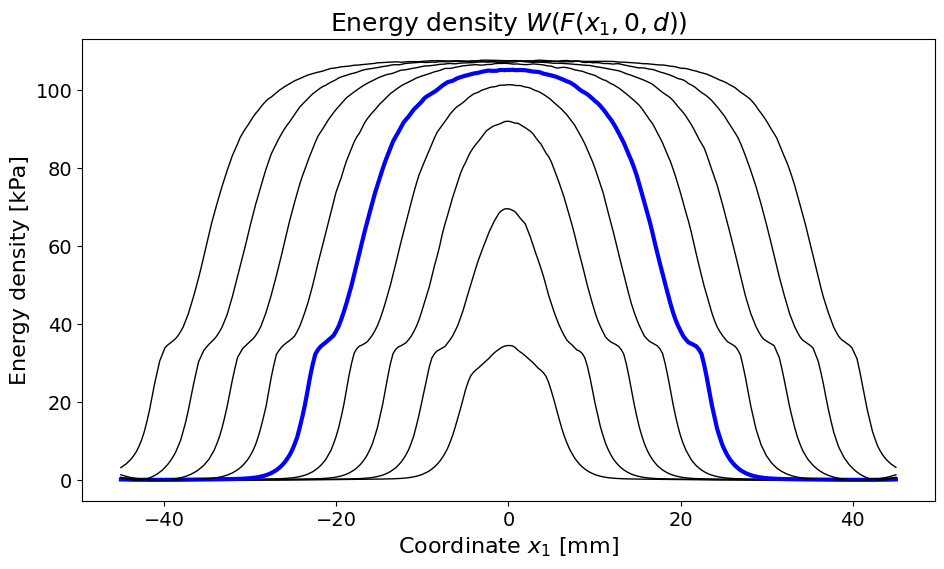

In [3]:
### Code for the Figure of Sec.4.3.2. of the moving front
### Run first the first cell

import pandas as pd
import matplotlib.pyplot as plt

# More stable parameters
G = 0.13               # measured in MPa
entropic_unit = 136.6  # k_B*T/V_m measured in MPa
phi0 = 0.2
chi =  0.348           # J. Elast. 2022, Sect. 3.4
rho = 1.23e-6          # measured in kg/mm³
g = 9.8                # measured in m/s²
AA = 1e5

# Most commonly changed parameters
order = 2
coarse_flag = 0

thickness = 3.00
if thickness==3.00:
    L= 90.0
    d = 3.00
    w = 23.5
elif thickness==1.62:
    L= 90.0
    d = 1.62
    w = 15.0

print('---- Thickness [mm]: {:.2f}'.format(d))

#
aux_spamwriter = []
aux_csv = [] 
aux_csv.append('d [mm]')
aux_csv.append('delta')
aux_csv.append('x_1')
aux_csv.append('W(x_1,0,d) [kPa]')
aux_spamwriter.append(aux_csv)

##
folder_name_suffix = str(int(d)) + '_' + str(int(d%1*100)).zfill(2)
if coarse_flag!=0:
    folder_name_suffix += '_coarse'
delta_values = np.loadtxt('meshes' + folder_name_suffix + '/deltas')

##
gel = gel_3D(length=L, thickness=d,width=w)
gravity = CoefficientFunction((0,-g, 0))

lambdaUniaxial = gel.lambdaUniaxial
lambdaEquiBiaxial = gel.lambdaEquiBiaxial
lambda_iso = gel.lambda_iso
wUniaxial = gel.wUniaxial
wEquiBiaxial = gel.wEquiBiaxial
wIso = 0

#
first_index_delta = 0
last_index_delta = 8
indexes_deltas = range(first_index_delta, last_index_delta+1)

fig, ax = plt.subplots(figsize=(11,6))
ax.set_xlabel('Coordinate $x_1$ [mm]', fontdict={'fontsize':16})
ax.set_ylabel('Energy density [kPa]', fontdict={'fontsize':16})
ax.set_title('Energy density $W(F(x_1, 0, d))$', fontdict={'fontsize':18})
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

for index_delta in indexes_deltas:
    delta = delta_values[index_delta];
    mesh_file = 'meshes' + folder_name_suffix + '/mesh{}.vol.gz'.format(index_delta);
    mesh = Mesh(mesh_file)
    
    #
    fes = VectorH1(mesh, order=order, dirichlet="bonded", dirichlety="debonded")
    filename_suffix = "_d={:.2f}_delta={:.3f}".format(d, delta)
    filename='gridfunctions'+folder_name_suffix+\
                '/result_debonded3D'+filename_suffix+\
                "_order={}".format(order)\
    #
    u = GridFunction(fes)
    u.Load(filename + '.gfu')
    F = Id(3) + Grad(u)
    ###    
    GF_energy_density = GridFunction(H1(mesh, order=1))
    GF_energy_density.Set(gel.W(F)*1e3)
    #
    num_points = 300
    x1_values = np.linspace(-L/2, L/2, num_points)
    W_values = np.zeros(num_points)
    for k, x_1 in enumerate(x1_values):
        Mip = mesh(x_1, d, 0)
        W_value = GF_energy_density(Mip)
        W_values[k] = W_value
        #
        aux_csv = [] 
        aux_csv.append(round(d, 2))
        aux_csv.append(round(delta,1))
        aux_csv.append(round(x_1,1))
        aux_csv.append(round(W_value, 2))
        aux_spamwriter.append(aux_csv)
        
    if delta!=0.5:
        color='k'; linewidth=1;
    else:
        color='b'; linewidth=3;
    ax.plot(x1_values, W_values, color=color, linewidth=linewidth, label='$\delta$={:.1f}'.format(delta))
    # fig.legend()

fig.savefig('figures/d' + folder_name_suffix + '-moving_front.png')

with open('summary-moving_front_d={:.2f}'.format(d) +'.csv', 'w') as csvfile:
    spamwriter = csv.writer(csvfile)
    spamwriter.writerows(aux_spamwriter)